In [1]:
import os
from ultralytics import YOLO
from roboflow import Roboflow

# --- 1. データの準備 ---
# 自動でRoboflowからデータをダウンロードします
rf = Roboflow(api_key="OJhli9tA7VXWzXHAgQuj")
project = rf.workspace("g11-temb0").project("-8sx96")
version = project.version(4)
dataset = version.download("yolov11")

print(f"\nデータセットのダウンロード完了: {dataset.location}\n")

# --- 2. 学習の実行 ---
# エラー回避のため plots=False を設定しています
model = YOLO("yolo11n.pt")

print("学習を開始します...（時間がかかります）")

# 学習実行
results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=50,
    imgsz=640,
    plots=False  # 【重要】グラフ描画エラーを回避する設定
)

# --- 3. 保存場所の表示 ---
# 学習結果の保存先フォルダを動的に取得します
save_dir = model.trainer.save_dir
best_model_path = os.path.join(save_dir, "weights", "best.pt")

# わかりやすく絶対パス（フルパス）に変換
abs_path = os.path.abspath(best_model_path)

print("\n" + "="*50)
print("✅ 学習が正常に完了しました！")
print("="*50)
print(f"結果の保存フォルダ: {save_dir}")
print("-" * 20)
print("【重要】学習済みモデル(best.pt)の場所:")
print(abs_path)
print("="*50 + "\n")

print("推論（テスト）を行うときは、上記のパスをコピーして使ってください。")

loading Roboflow workspace...
loading Roboflow project...

データセットのダウンロード完了: /Users/mihiraryouta/ハッカソン/学内ハッカソン/asobitai/smart_doc_gen/services/正答検知-4

学習を開始します...（時間がかかります）
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.1 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/mihiraryouta/ハッカソン/学内ハッカソン/asobitai/smart_doc_gen/services/正答検知-4/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, mo

✅ モデルを読み込みます: /Users/mihiraryouta/ハッカソン/学内ハッカソン/asobitai/runs/detect/train8/weights/best.pt
推論を実行中...

0: 448x640 1 check, 2 circles, 32.9ms
Speed: 10.8ms preprocess, 32.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


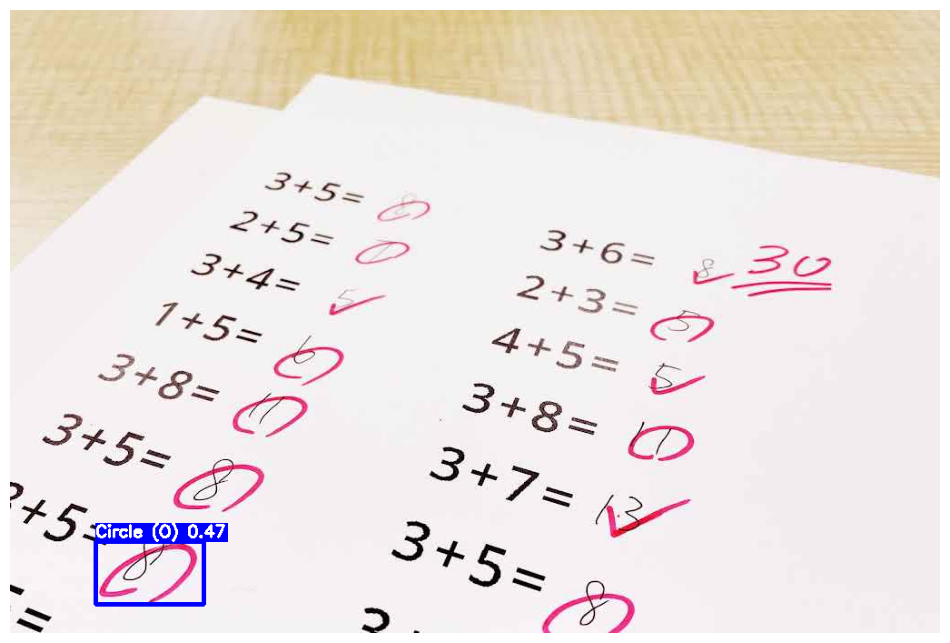

表示完了


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ==========================================
# 設定：ここを書き換えるだけでOKです
# ==========================================

# 1. ログで確認した「学習結果のフォルダ」
# ※ "/weights/best.pt" は自動で補完するようにしています
train_dir = "/Users/mihiraryouta/ハッカソン/学内ハッカソン/asobitai/runs/detect/train8"

# 2. テストしたい画像のパス
target_image = "/Users/mihiraryouta/ハッカソン/学内ハッカソン/asobitai/smart_doc_gen/services/sample.png"


# ==========================================
# 推論実行コード
# ==========================================

def run_inference_fixed_path(train_dir, image_path):
    # モデルファイルのパスを構築
    model_path = os.path.join(train_dir, "weights", "best.pt")

    # 1. パスチェック
    if not os.path.exists(model_path):
        print(f"❌ エラー: モデルファイルが見つかりません。")
        print(f"探した場所: {model_path}")
        print("パスが間違っていないか確認してください。")
        return

    print(f"✅ モデルを読み込みます: {model_path}")
    model = YOLO(model_path)
    
    # 2. 画像読み込み
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ エラー: 画像が見つかりません: {image_path}")
        return

    # 3. 推論実行
    print("推論を実行中...")
    results = model(img)

    # 4. 結果の描画
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            label = model.names[cls]

            if conf < 0.4: continue # 信頼度40%未満は無視

            # ラベルごとの色設定
            if "maru" in label or "circle" in label:
                color = (255, 0, 0)      # 青
                text_label = "Circle (O)"
            elif "batsu" in label or "cross" in label:
                color = (0, 0, 255)      # 赤
                text_label = "Cross (X)"
            elif "check" in label:
                color = (0, 255, 0)      # 緑
                text_label = "Check (V)"
            elif "sankaku" in label or "triangle" in label:
                color = (0, 255, 255)    # 黄色
                text_label = "Triangle (^)"
            else:
                color = (128, 128, 128)
                text_label = label

            # 枠を描画
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
            
            # 文字を描画（背景付き）
            label_text = f"{text_label} {conf:.2f}"
            (w, h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(img, (x1, y1 - 20), (x1 + w, y1), color, -1)
            cv2.putText(img, label_text, (x1, y1 - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # 5. 表示
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print("表示完了")

# 関数を実行
run_inference_fixed_path(train_dir, target_image)